# Gaussian Progress Regression (GPR) #

Lecturer: Harold Soh
TAs: Abdul Fatir and Chen Kaiqi

Accompanying Code for Lecture 11 on Gaussian Processes

Acknowledgements:
- SciKitLearn Tutorial: https://scikit-learn.org/stable/auto_examples/ 



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, RationalQuadratic, ExpSineSquared

## Load Data: COVID-19 in Singapore ##

For our data, we'll load up the number of confirmed COVID-19 cases in Singapore. I've put the data directly in this notebook but the original data is from Kaggle (https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/data) 

Data is from 22 Jan 2020 to 30 Mar 2020

*Note*: We are using this dataset simply for illustrative purposes. Usage of the vanilla GP for regression for this dataset is not wholly appropriate since we cannot have a negative number of cases.

In [2]:
Y = np.array([0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432,455,509,558,631,683,732,802,844,879])
Y = Y/100.0
dY = np.diff(Y)
Y = Y.reshape([len(Y),1])
dY = dY.reshape([len(dY),1]) # number of new cases
X = np.array(range(len(Y)))
X = X.reshape([len(X),1])

print("%d data-points"%len(Y))

69 data-points


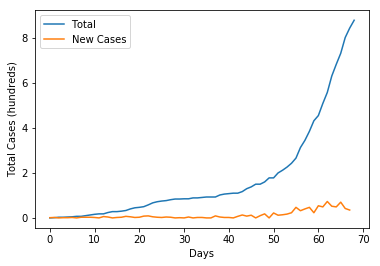

In [3]:
plt.plot(Y, label="Total")
plt.xlabel("Days")
plt.ylabel("Total Cases (hundreds)")
plt.plot(dY, label="New Cases")
plt.legend()

## Create our model ##
Create our model and plot the predictions. We are going to model the total number of cases v.s. the number of days

In [4]:
# set the kernel (covariance) function
kernel = ConstantKernel(constant_value=50)*RBF(length_scale=20) + \
         ConstantKernel(constant_value=50)*Matern(length_scale=20) + \
         WhiteKernel(0.1, noise_level_bounds=[0.1, 100.0])

In [6]:
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp.fit(X[:65],Y[:65]) #train only using the first 65 data points

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=7.07**2 * RBF(length_scale=20) + 7.07**2 * Matern(length_scale=20, nu=1.5) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False, optimizer=None,
             random_state=None)

In [7]:

# Make predictions
Xt = np.arange(81)
Xt = Xt.reshape(-1,1)
Y_mean, Y_std = gp.predict(Xt, return_std=True)


In [8]:
# plot 
def plotGPResults(Xt, Y_mean, Y_std, Xtrain=None, Ytrain=None, Xtrue=None, Ytrue=None, Ylim=13):
    Xt = Xt.flatten()
    Y_mean = Y_mean.flatten()
    Y_std = Y_std.flatten()
    plt.plot(Xt, Y_mean)
    
    # plot the curve
    plt.fill_between(Xt, 
                     Y_mean - Y_std, 
                     Y_mean + Y_std, 
                     alpha=0.1, color='k')
    plt.fill_between(Xt, 
                     Y_mean - (Y_std**2), 
                     Y_mean + (Y_std**2), 
                     alpha=0.05, color='k')
    
    # plot the points
    if (Xtrain is not None) and (Ytrain is not None):
        plt.plot(Xtrain, Ytrain, 'x', color='k')
    
    # plot the test points
    if (Xtrue is not None) and (Ytrue is not None):
        plt.plot(Xtrue, Ytrue, '.', color='r')
    
    plt.xlim([0,len(Xt)])
    plt.ylim([0,Ylim])
    plt.xlabel("Days")
    plt.ylabel("Total Num. Cases")
    plt.legend(loc=2)

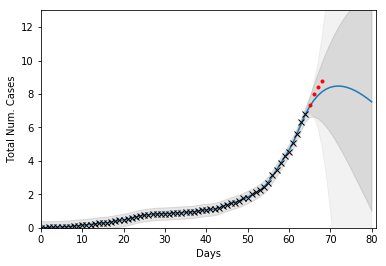

In [9]:
plotGPResults(Xt, Y_mean, Y_std, X[:65], Y[:65], X[65:], Y[65:])

## Hyperparameter Optimization ##
We can also optimize the kernel parameters using an Empirical Bayesian approach via Type-II Maximum Likelihood, i.e., we optimize $p(y|\theta, X)$ with respect to $\theta$. 

**Warning**: ML-II can overfit the training data. 

In [10]:
# Empirical Bayes (ML-II Optization)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
gp.fit(X[0:65],Y[0:65]);

In [11]:
gp.kernel_

8.56**2 * RBF(length_scale=25.6) + 2.45**2 * Matern(length_scale=9.89e+04, nu=1.5) + WhiteKernel(noise_level=0.1)

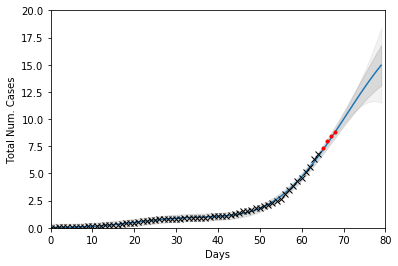

In [12]:
# Make predictions
Xt = np.arange(80)
Xt = Xt.reshape(-1,1)
Y_mean, Y_std = gp.predict(Xt, return_std=True)

plotGPResults(Xt, Y_mean, Y_std, X[:65], Y[:65], X[65:], Y[65:], Ylim=20)

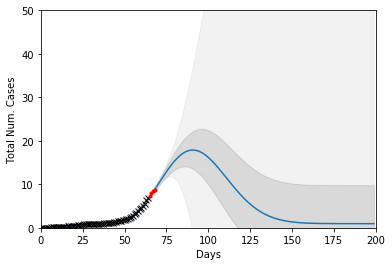

In [14]:
# Make longer-range predictions
Xt = np.arange(200)
Xt = Xt.reshape(-1,1)
Y_mean, Y_std = gp.predict(Xt, return_std=True)
plotGPResults(Xt, Y_mean, Y_std, X[:65], Y[:65], X[65:], Y[65:], Ylim=50);

## Sampling from the GP Prior ##

In the lecture, we learnt how the GP specifies a prior over functions.

### Radial Basis Function (RBF) Kernel ###
Let us first sample from this prior with the RBF kernel.

$$k_{RBF}(\mathbf{x},\mathbf{x}^′ )=\exp⁡\left(−\frac{\|\mathbf{x}−\mathbf{x}^′\|^2}{2l^2}\right)$$

**Exercise:** How does $k_{RBF}$ change as the $|\mathbf{x}−\mathbf{x}'|$ grows larger? How does it change with the lengthscale $l$?

More information: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py

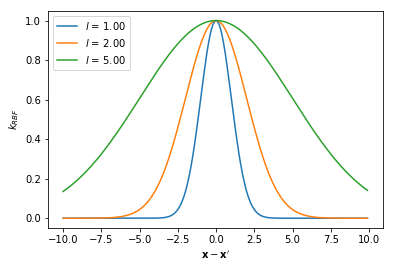

In [19]:
Xt = np.arange(-10,10,0.1)
Xt = Xt.reshape(-1,1)
for ls in {1, 2, 5}:
    kernel = RBF(length_scale=ls)
    plt.plot(Xt,  kernel([[0]], Xt).T, label="$l$ = %.2f"%ls)

plt.xlabel("$\mathbf{x} - \mathbf{x}'$")
plt.ylabel("$k_{RBF}$")
plt.legend(loc=2);

In [20]:
# simple plotting function for the samples
def plotGPSamples(Xt, Y_samples, Y_mean, Y_std, title):

    Xt = Xt.flatten()
    Y_mean = Y_mean.flatten()
    Y_std = Y_std.flatten()
    
    plt.plot(Xt, Y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(Xt, Y_mean - Y_std, Y_mean + Y_std, alpha=0.1, color='k')
    plt.fill_between(Xt, Y_mean - Y_std**2, Y_mean + Y_std**2, alpha=0.05, color='k')
    plt.plot(Xt, Y_samples, lw=1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    

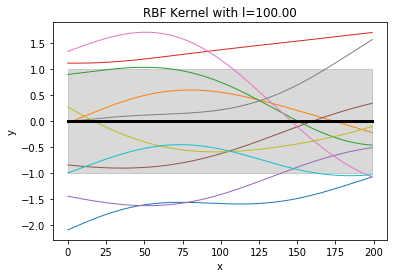

In [22]:
# set the kernel (covariance) function
ls = 100
kernel = RBF(length_scale=ls) # set an RBF kernel
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None)
# not fitting anything!
  
# draw samples 
Xt = np.arange(200)
Xt = Xt.reshape(-1,1)
Y_mean, Y_std = gp.predict(Xt, return_std=True)
Y_samples = gp.sample_y(Xt, 10) #this draw the samples

plotGPSamples(Xt, Y_samples, Y_mean, Y_std, "RBF Kernel with l=%.2f"%ls);

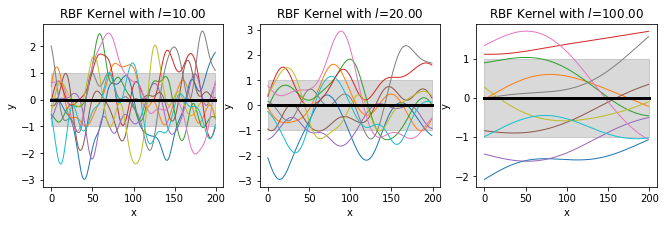

In [45]:
# set the kernel (covariance) function
i=1
hyperparams = (10,20,100)
plt.figure(figsize=(11,3))
for ls in hyperparams:
    kernel = RBF(length_scale=ls) # set an RBF kernel
    gp = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    # not fitting anything!

    # draw samples 
    Xt = np.arange(200)
    Xt = Xt.reshape(-1,1)
    Y_mean, Y_std = gp.predict(Xt, return_std=True)
    Y_samples = gp.sample_y(Xt, 10) #this draw the samples
    plt.subplot(1,len(hyperparams),i)
    plotGPSamples(Xt, Y_samples, Y_mean, Y_std, "RBF Kernel with $l$=%.2f"%ls);
    ylim=(-3,3)
    i+=1

### A Periodic Kernel ###
Let's now try the ExpSineSquared kernel which allows us to model periodic functions. 

$$k(x_i, x_j) = \exp(-2 (\sin(\pi / p_d * d(\mathbf{x}_i, \mathbf{x}_j)) / l) ^ 2)$$

There are two parameters, lengthscale and periodicity, but we will just vary periodicity for this exercise.

**Exercise:** Is this kernel stationary? Is it isotropic? 

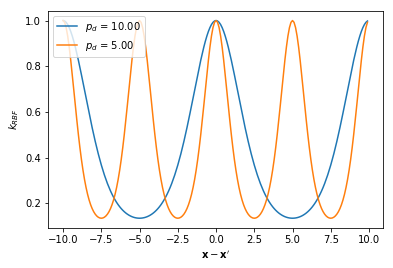

In [46]:
Xt = np.arange(-10,10,0.1)
Xt = Xt.reshape(-1,1)
for th in {5, 10}:
    kernel = ExpSineSquared(periodicity=th)
    plt.plot(Xt,  kernel([[0]], Xt).T, label="$p_d$ = %.2f"%th)

plt.xlabel("$\mathbf{x} - \mathbf{x}'$")
plt.ylabel("$k_{RBF}$")
plt.legend(loc=2);

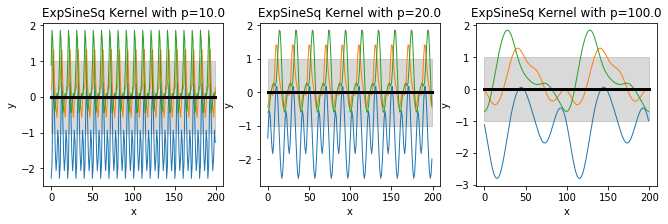

In [47]:
i=1
hyperparams = (10,20,100)
plt.figure(figsize=(11,3))
for th in hyperparams:
    kernel = ExpSineSquared(periodicity=th) # set an ExpSineSquared kernel
    gp = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    # not fitting anything!

    # draw samples 
    Xt = np.arange(200)
    Xt = Xt.reshape(-1,1)
    Y_mean, Y_std = gp.predict(Xt, return_std=True)
    Y_samples = gp.sample_y(Xt, 3) #this draw the samples
    plt.subplot(1,len(hyperparams),i)
    plotGPSamples(Xt, Y_samples, Y_mean, Y_std, "ExpSineSq Kernel with p=%.1f"%th);
    ylim=(-3,3)
    i+=1

**Further Exploration**: I encourage you to play around with different kernels to get a feel. More information: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py

## Automatic Relevance Determination ##

We will use a synthetic function that depends only on $x_0$ and we add in a noisy irrelevant input $x_1$. 

We will create a GP with an ARD kernel:

$$k(\mathbf{x}, \mathbf{x}') = \exp(-(\mathbf{x}- \mathbf{x}')^\top \mathbf{M}(\mathbf{x}- \mathbf{x}') )$$
where $\mathbf{M}$ is a diagonal matrix of inverse lengthscales

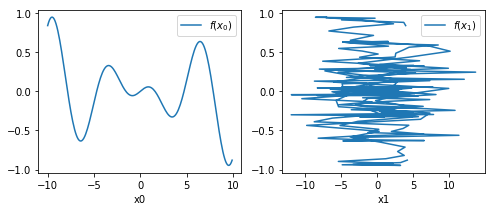

In [48]:
def testf(x):
    x0 = x[:,0]
    return np.cos(x0)*(x0)/10

xr = np.arange(-10,10,0.1)
x1 = 5*np.random.randn(len(xr))
X = np.column_stack([xr,x1])
Y = testf(X)
plt.figure(figsize=(8,3))
for i in (0,1):
    plt.subplot(1,2,i+1)
    plt.plot(X[:,i], Y, label='$f(x_%d)$'%i)
    plt.xlabel("x%d"%i)
    plt.legend()


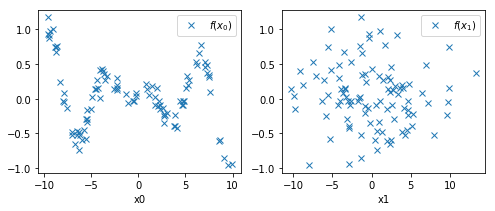

In [38]:
# gneerate some training data
x0 = np.random.uniform(-10, 10, size=100)
x1 = 5*np.random.randn(len(x0))
X = np.column_stack([x0,x1])
Y = testf(X) + 0.1*np.random.randn(len(x0))

plt.figure(figsize=(8,3))
for i in (0,1):
    plt.subplot(1,2,i+1)
    plt.plot(X[:,i], Y, 'x', label='$f(x_%d)$'%i)
    plt.xlabel("x%d"%i)
    plt.legend()

### Create our GP and Optimize the Hyperparameters ###

In [40]:
# Empirical Bayes (ML-II Optization)
ARDkernel = ConstantKernel(1.0)*RBF(100*np.ones(2), length_scale_bounds=(0.01, 1e6)) + WhiteKernel(noise_level=0.1)
gp = GaussianProcessRegressor(kernel=ARDkernel, n_restarts_optimizer=2)
gp.fit(X,Y);

# Empirical Bayes (ML-II Optization)
RBFkernel = ConstantKernel(1.0)*RBF(100, length_scale_bounds=(0.01, 1e6)) + WhiteKernel(noise_level=0.1)
gp_iso = GaussianProcessRegressor(kernel=RBFkernel, n_restarts_optimizer=2)
gp_iso.fit(X,Y);

### After Learning / Optimization ###
Let's print and plot out the lengthscales. If all went to plan, you should see that the lengthscale for $x_0$ is very small relative to $x_1$. Recall that the larger the lengthscale, the less important the feature is. 

In [41]:
gp.kernel_

0.65**2 * RBF(length_scale=[1.88, 117]) + WhiteKernel(noise_level=0.00791)

Text(0,0.5,'Log Lengthscale')

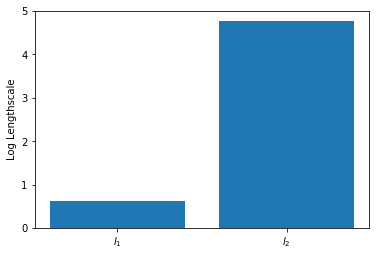

In [42]:
thetas = gp.kernel_.get_params()
plt.bar(['$l_1$','$l_2$'], np.log(thetas['k1__k2__length_scale']))
plt.ylabel("Log Lengthscale")

### Plot predictions ###
Let's see how well the model predicts the true curve. We'll compare against the kernel with the (isotropic) RBF kernel.

In [43]:
Xt = np.column_stack([xr,2*np.random.randn(len(xr))])
Y_true = testf(Xt)

# ARD kernel
Y_mean, Y_std = gp.predict(Xt, return_std=True)

# isotropic RBF
Y_iso_mean, Y_iso_std = gp_iso.predict(Xt, return_std=True)


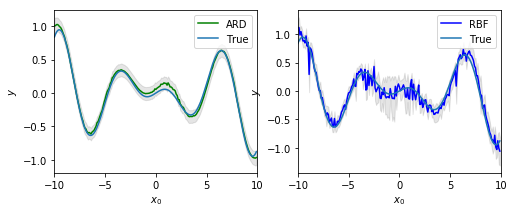

In [44]:
Ys = ((Y_mean, Y_std), (Y_iso_mean, Y_iso_std))

labels = ('ARD', 'RBF')
colors = ('g','b')

plt.figure(figsize=(8,3))
for i in (0,1):
    
    Y_pred_mean = Ys[i][0]
    Y_pred_std = Ys[i][1]
    
    plt.subplot(1,2,i+1)
    plt.plot(Xt[:,0], Y_pred_mean, label=labels[i], color=colors[i]);
    plt.fill_between(Xt[:,0], Y_pred_mean - Y_pred_std, Y_pred_mean + Y_pred_std, alpha=0.1, color='k')

    plt.plot(Xt[:,0], Y_true, label='True');
    plt.xlim([-10,10])
    plt.ylabel("$y$");
    plt.xlabel("$x_0$");
    plt.legend();